In [2]:
from sklearn.model_selection import train_test_split
import numpy as np
import pywt
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LogisticRegression

from glob import glob
import scipy
from scipy.signal import butter, lfilter, convolve, boxcar
from scipy.signal import freqz
from scipy.fftpack import fft, ifft
import os

from sklearn.preprocessing import StandardScaler
import pandas as pd
import os, sys
import numpy as np
import matplotlib.pyplot as plt

## Visuallization

In [3]:
signal_data = pd.read_csv(r"...\grasp-and-lift-eeg-detection\train\subj1_series1_data.csv")
label = pd.read_csv(r"...\grasp-and-lift-eeg-detection\train\subj1_series1_events.csv")
signal_data.head()

,id,Fp1,Fp2,F7,F3,Fz,F4,F8,FC5,FC1,...,P7,P3,Pz,P4,P8,PO9,O1,Oz,O2,PO10
0,subj1_series1_0,-31,363,211,121,211,15,717,279,35,...,536,348,383,105,607,289,459,173,120,704
1,subj1_series1_1,-29,342,216,123,222,200,595,329,43,...,529,327,369,78,613,248,409,141,83,737
2,subj1_series1_2,-172,278,105,93,222,511,471,280,12,...,511,319,355,66,606,320,440,141,62,677
3,subj1_series1_3,-272,263,-52,99,208,511,428,261,27,...,521,336,356,71,568,339,437,139,58,592
4,subj1_series1_4,-265,213,-67,99,155,380,476,353,32,...,550,324,346,76,547,343,446,171,67,581


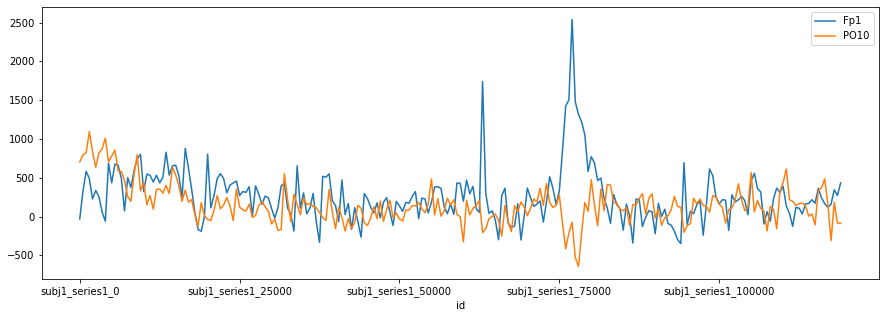

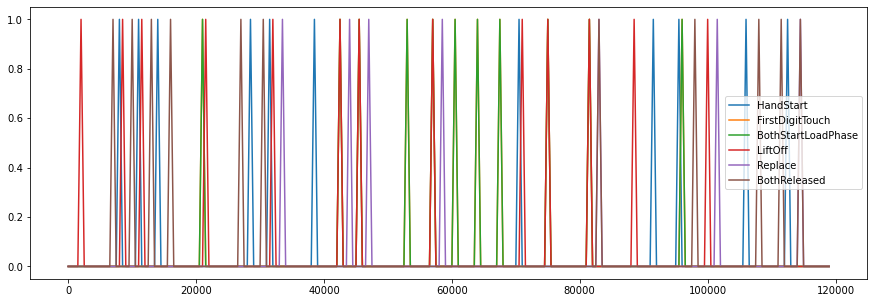

In [5]:
axis = plt.gca()
downSampleToShow = 500
signal_data[::downSampleToShow].plot(x="id", y="Fp1", ax=axis)
signal_data[::downSampleToShow].plot(x="id", y="PO10", ax=axis, figsize=(15,5))
label[::downSampleToShow].plot(figsize=(15,5))
plt.show()

In [6]:
eeg_channels = signal_data.columns.drop('id')
labels = label.columns.drop('id')
train_set_complete = pd.concat([signal_data,label], axis=1)
train_set_complete.insert(0, "order", range(0, len(train_set_complete)))
train_set_complete.head()

,order,id,Fp1,Fp2,F7,F3,Fz,F4,F8,FC5,...,Oz,O2,PO10,id,HandStart,FirstDigitTouch,BothStartLoadPhase,LiftOff,Replace,BothReleased
0,0,subj1_series1_0,-31,363,211,121,211,15,717,279,...,173,120,704,subj1_series1_0,0,0,0,0,0,0
1,1,subj1_series1_1,-29,342,216,123,222,200,595,329,...,141,83,737,subj1_series1_1,0,0,0,0,0,0
2,2,subj1_series1_2,-172,278,105,93,222,511,471,280,...,141,62,677,subj1_series1_2,0,0,0,0,0,0
3,3,subj1_series1_3,-272,263,-52,99,208,511,428,261,...,139,58,592,subj1_series1_3,0,0,0,0,0,0
4,4,subj1_series1_4,-265,213,-67,99,155,380,476,353,...,171,67,581,subj1_series1_4,0,0,0,0,0,0


HandStart = red
FirstDigitTouch = purple
BothStartLoadPhase = black
LiftOff = green
Replace = yellow
BothReleased = blue


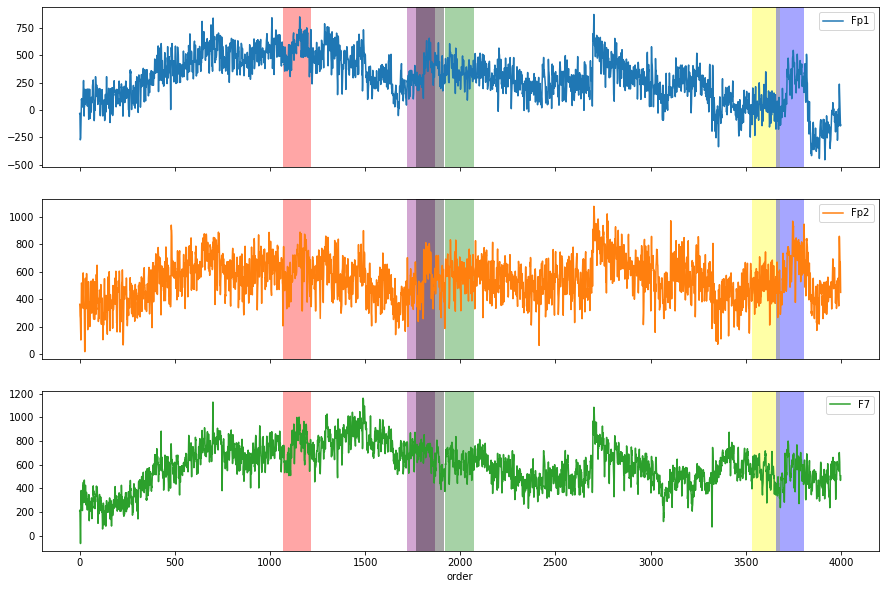

In [7]:
def highlight(indices,ax,color):
    i=0
    while i<len(indices):
        ax.axvspan(indices[i]-0.5, indices[i]+0.5, facecolor=color, edgecolor='none', alpha=.35)
        i+=1
secondsToShow = 8
channelsToShow = 3
labelsToShow = 6

sample_set = train_set_complete[train_set_complete["order"] < secondsToShow*500].drop("id", axis=1).set_index("order") #sample rate is 500hz 
colors=["red","purple","black","green", "yellow", "blue"]
axes = sample_set.plot(y=eeg_channels[:channelsToShow],subplots=True, figsize=(15,10))
for i in range(0, len(labels)):
    print(labels[i], "=", colors[i])
    
for axis in axes:    
    colorindex = 0
    for label in labels[:labelsToShow]:
        highlight(sample_set[sample_set[label]==1].index, axis, colors[colorindex])        
        colorindex = colorindex + 1
plt.show()

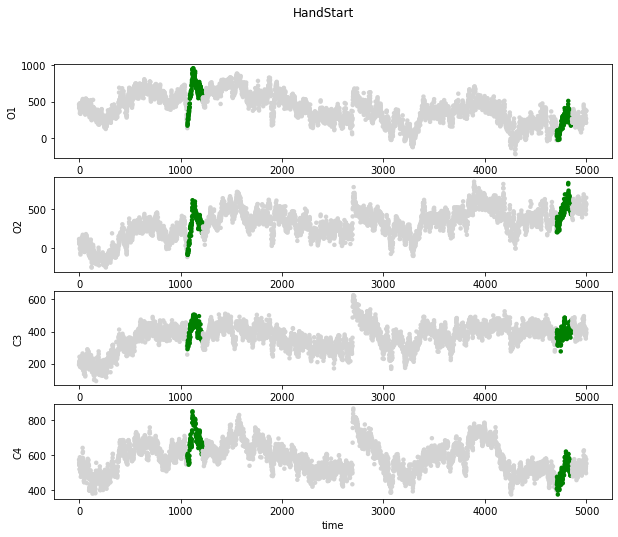

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

sub1_events_file = r"...\grasp-and-lift-eeg-detection\train\subj1_series1_events.csv"
sub1_data_file = r"...\grasp-and-lift-eeg-detection\train\subj1_series1_data.csv"

sub1_events = pd.read_csv(sub1_events_file)
sub1_data = pd.read_csv(sub1_data_file)

sub1 = pd.concat([sub1_events, sub1_data], axis = 1)
sub1["time"] = range(0, len(sub1))

sample_sub1 = sub1[sub1["time"] < 5000]

event = "HandStart"
event1 = "FirstDigitTouch"
EventColors = ["lightgrey", "green","blue"]

plot_columns = ["O1", "O2", "C3", "C4"]

fig, axes = plt.subplots(nrows=len(plot_columns), ncols=1)
fig.suptitle(event)
for (i, y) in enumerate(plot_columns):
    # Plot all the columns
    sample_sub1.plot(kind="scatter", x="time", y=y, edgecolors='none', ax=axes[i], figsize=(10,8), c=sample_sub1[event].apply(EventColors.__getitem__))

## EEG DATA

In [10]:
fname= r"...\grasp-and-lift-eeg-detection\train"

def prepare_data_train(fname):
    """ read and prepare training data """
    # Read data
    data = pd.read_csv(fname)
    # events file
    events_fname = fname.replace('_data','_events')
    # read event file
    labels= pd.read_csv(events_fname)
    clean=data.drop(['id' ], axis=1)#remove id
    labels=labels.drop(['id' ], axis=1)#remove id
    return  clean,labels

def prepare_data_test(fname):
    """ read and prepare test data """
    # Read data
    data = pd.read_csv(fname)
    return data

In [11]:
subjects = range(1,4)
from glob import glob
import pandas as pd
ids_tot = []
pred_tot = []
X_train_butter = []
from sklearn.model_selection import train_test_split
import numpy as  np

###loop on subjects and 8 series for train data + 2 series for test data
y_raw= []
raw = []
y_rawt= []
rawt = []
for subject in subjects:
    
  ################ READ DATA ################################################
  fnames =  sorted(glob(r'...\grasp-and-lift-eeg-detection\train\subj%d_series*_data.csv' % (subject)))[:6]
  for fname in fnames:
    data,labels=prepare_data_train(fname)
    raw.append(data)
    y_raw.append(labels)

  for fname in fnames:
      with open(fname) as myfile:
        head = [next(myfile) for x in range(10)]
      
        
X = pd.concat(raw)
y = pd.concat(y_raw)
    #transform in numpy array
    #transform train data in numpy array
X_train =np.asarray(X.astype(float))
Y_train = np.asarray(y.astype(float))

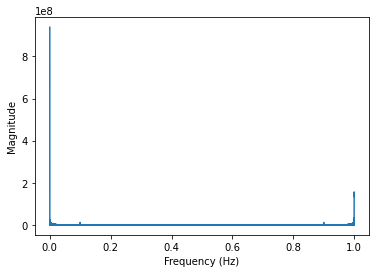

In [12]:
import numpy as np
from matplotlib import pyplot as plt

# Compute the FFT of the signal
n = len(X_train[:,1])
fhat = np.fft.fft(X_train[:,1], n)

# Compute the frequencies associated with each FFT coefficient
dt = 1 # assuming a sampling interval of 1
freq = (1/(dt*n)) * np.arange(n)

# Plot the magnitude of the FFT coefficients
plt.plot(freq, np.abs(fhat))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.show()

In [13]:
from scipy import signal
scaler = StandardScaler()
def data_preprocess(X):
    # Scale data
    X_scale = scaler.fit_transform(X)

    # Create the low-pass filter
    sos = signal.butter(50, 0.1, 'low', fs=2, output='sos')
    X_prep = X_scale.copy()
    # Apply the low-pass filter to each signal in X_prep
    for i in range(X_scale.shape[1]):
       X_prep[:,i] = signal.sosfilt(sos, X_scale[:,i])
    
    return X_scale, X_prep
X_train_scale, X_train_prep = data_preprocess(X_train)

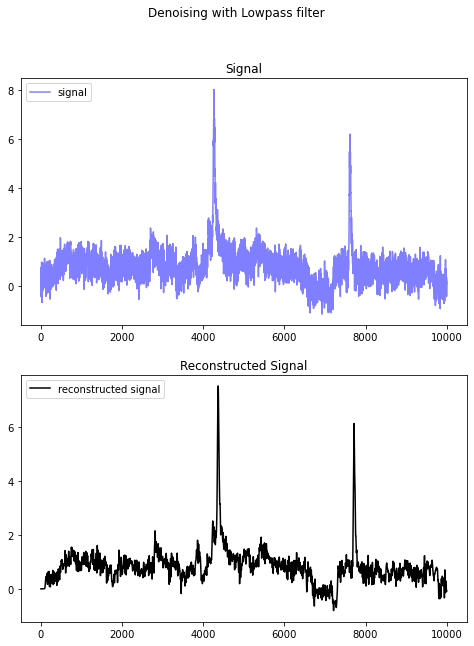

In [14]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))

ax1.plot(X_train_scale[:10000, 1], label='signal', color="b", alpha=0.5)
ax1.set_title('Signal')
ax1.legend(loc='upper left')

ax2.plot(X_train_prep[:10000, 1], label='reconstructed signal', color="k")
ax2.set_title('Reconstructed Signal')
ax2.legend(loc='upper left')

fig.suptitle('Denoising with Lowpass filter')
plt.show()

## WAVELET

In [15]:
def wavelet_denoising(x, wavelet='db2', level=3):
    coeff = pywt.wavedec(x, wavelet, mode="per")
    sigma = (1/0.6745) * madev(coeff[-level])
    uthresh = sigma * np.sqrt(2 * np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])
    return pywt.waverec(coeff, wavelet, mode='per')
def madev(d, axis=None):
    """ Mean absolute deviation of a signal """
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)
X_train_wavelet = wavelet_denoising(X_train_prep)

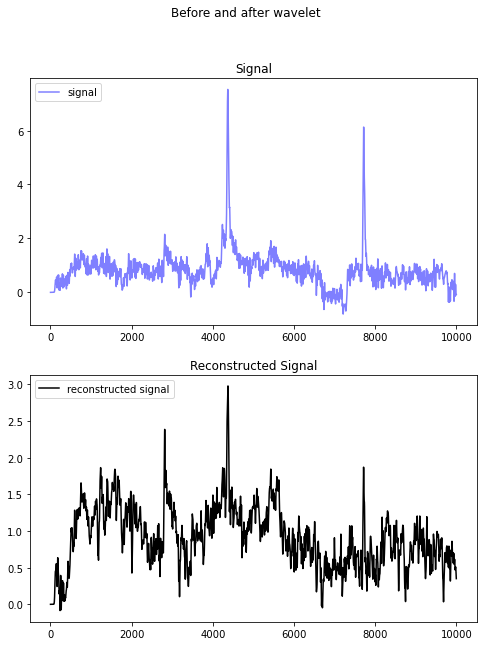

In [16]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))

ax1.plot(X_train_prep[:10000, 1], label='signal', color="b", alpha=0.5)
ax1.set_title('Signal')
ax1.legend(loc='upper left')

ax2.plot(X_train_wavelet[:10000, 1], label='reconstructed signal', color="k")
ax2.set_title('Reconstructed Signal')
ax2.legend(loc='upper left')

fig.suptitle('Before and after wavelet')
plt.show()

## PCA

In [17]:
from sklearn.decomposition import PCA

pca = PCA().fit(X_train_wavelet)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.9) + 1
print(d)

4


In [18]:
pca = PCA(n_components=d) # specify the number of components to keep 
X_train_wavelet_pca = pca.fit_transform(X_train_wavelet) 
signal_recovered = pca.inverse_transform(X_train_wavelet_pca)

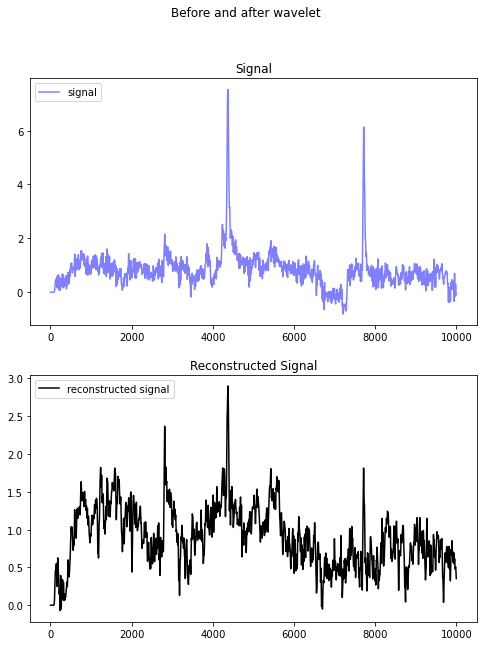

In [19]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))

ax1.plot(X_train_prep[:10000, 1], label='signal', color="b", alpha=0.5)
ax1.set_title('Signal')
ax1.legend(loc='upper left')

ax2.plot(signal_recovered[:10000, 1], label='reconstructed signal', color="k")
ax2.set_title('Reconstructed Signal')
ax2.legend(loc='upper left')

fig.suptitle('Before and after wavelet')
plt.show()

## TRAIN VAL SLPIT

In [20]:
splitrate=-X_train_wavelet_pca.shape[0]//5*2
xval=X_train_wavelet_pca[splitrate:splitrate//2]
yval=Y_train[splitrate:splitrate//2]
xtest=X_train_wavelet_pca[splitrate//2:]
ytest=Y_train[splitrate//2:]
xtrain=X_train_wavelet_pca[:splitrate]
ytrain=Y_train[:splitrate]

## CNN

In [59]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import LSTM, BatchNormalization, Conv2D, Flatten, MaxPooling2D, Dropout
from keras.optimizers import Adam, SGD
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,roc_curve,auc
import tensorflow as tf
from keras.layers import LeakyReLU


In [22]:
input_shape=(1000//50, d, 1)
input_shape

(20, 4, 1)

In [64]:
import numpy as np
load = 1
time_steps = 1000
subsample = 50
model = Sequential()
model.add(Conv2D(64, (7, 7), activation='relu', padding='same', input_shape=(time_steps//subsample, d, 1)))
model.add(BatchNormalization())
#model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (5, 5), activation='relu', padding='same'))
model.add(BatchNormalization())
#model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
#model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
#model.add(Dropout(0.2))
model.add(Dense(6, activation = "relu"))
# I have tested with relu, sigmoid, softmax activation function and relu gave the best score so I choose relu

adam = Adam(lr = 0.00001)

model.compile(optimizer = adam, loss = "categorical_crossentropy", metrics = ['accuracy','mse'])

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 20, 4, 64)         3200      
                                                                 
 batch_normalization_17 (Bat  (None, 20, 4, 64)        256       
 chNormalization)                                                
                                                                 
 conv2d_16 (Conv2D)          (None, 20, 4, 64)         102464    
                                                                 
 batch_normalization_18 (Bat  (None, 20, 4, 64)        256       
 chNormalization)                                                
                                                                 
 conv2d_17 (Conv2D)          (None, 20, 4, 64)         36928     
                                                                 
 batch_normalization_19 (Bat  (None, 20, 4, 64)       

C:\Users\buitr\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [37]:
def valgenerator():
    while 1:
        batch_size=32
        x_time_data = np.zeros((batch_size, time_steps//subsample, d))
        yy = []
        for i in range(batch_size):
            random_index = np.random.randint(0, len(xval)-time_steps)
            x_time_data[i] = xval[random_index:random_index+time_steps:subsample]
            yy.append(yval[random_index + time_steps])
        yy = np.asarray(yy)
        yield x_time_data, yy

import time
start=time.time()
def generator(batch_size):
    while 1:
        
        x_time_data = np.zeros((batch_size, time_steps//subsample, d))
        yy = []
        for i in range(batch_size):
            random_index = np.random.randint(0, len(xtrain)-time_steps)
            x_time_data[i] = xtrain[random_index:random_index+time_steps:subsample]
            yy.append(ytrain[random_index + time_steps])
        yy = np.asarray(yy)
        yield x_time_data, yy

In [65]:
from keras.callbacks import EarlyStopping

# define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(generator(32), steps_per_epoch=200, epochs=50,
                              validation_data=valgenerator(), validation_steps=100)

Epoch 1/50
200/200 [==============================] - 5s 21ms/step - loss: nan - accuracy: 0.7411 - mse: nan - val_loss: nan - val_accuracy: 0.9069 - val_mse: nan
Epoch 2/50
200/200 [==============================] - 4s 19ms/step - loss: nan - accuracy: 0.9147 - mse: nan - val_loss: nan - val_accuracy: 0.8966 - val_mse: nan
Epoch 3/50
200/200 [==============================] - 4s 20ms/step - loss: nan - accuracy: 0.9164 - mse: nan - val_loss: nan - val_accuracy: 0.9056 - val_mse: nan
Epoch 4/50
200/200 [==============================] - 4s 19ms/step - loss: nan - accuracy: 0.9197 - mse: nan - val_loss: nan - val_accuracy: 0.9022 - val_mse: nan
Epoch 5/50
200/200 [==============================] - 4s 19ms/step - loss: nan - accuracy: 0.9184 - mse: nan - val_loss: nan - val_accuracy: 0.9013 - val_mse: nan
Epoch 6/50
200/200 [==============================] - 4s 20ms/step - loss: nan - accuracy: 0.9180 - mse: nan - val_loss: nan - val_accuracy: 0.9025 - val_mse: nan
Epoch 7/50
200/200 [==

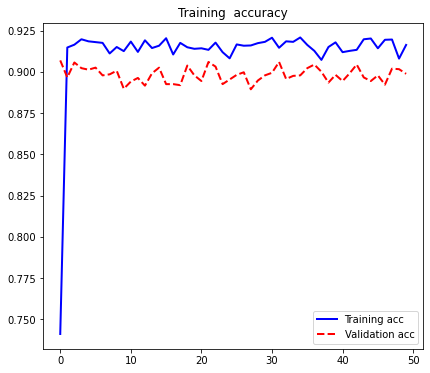

In [66]:
def plot_training_history(history):
    acc = history.history['accuracy']
    loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))
 
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training acc',linewidth=2)
    plt.plot(epochs, val_acc, 'r--', label='Validation acc',linewidth=2)
    plt.title('Training  accuracy')
    plt.legend()
    plt.show()
plot_training_history(history)

In [34]:
time_steps = 1000
subsample = 50
def val_generator():
    while 1:
        batch_size=32
        x_time_data = np.zeros((batch_size, time_steps//subsample, d))
        yy = []
        for i in range(batch_size):
            random_index = np.random.randint(0, len(xtest)-time_steps)
            x_time_data[i] = xtest[random_index:random_index+time_steps:subsample]
            yy.append(yval[random_index + time_steps])
        yy = np.asarray(yy)
        yield x_time_data, yy


In [68]:
from sklearn.metrics import accuracy_score

gen_data = val_generator()
l=["Handstart (HS)","Grasping (GS)","Lift (LT)","Hold (HD)","Replace (RP)","Release (RL)"]
num_test = 5000
batch_size = 32
num_batches = num_test // batch_size
y_score = np.zeros((num_test, 6))
y_test = np.zeros((num_test, 6))

for i in range(num_batches):
    x_test, y_test_batch = next(gen_data)
    x_test = np.expand_dims(x_test, axis=-1)
    y_score_batch = model.predict(x_test).reshape(batch_size, 6)
    y_test[i*batch_size:(i+1)*batch_size,:] = y_test_batch
    y_score[i*batch_size:(i+1)*batch_size,:] = y_score_batch
    y_score = (y_score > 0.5).astype(int)

accuracy = accuracy_score(y_test, y_score)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

1/1 [==============================] - 0s 16ms/step
Accuracy: 87.32%


## LSTM

In [71]:
time_steps = 1000
subsample = 10
model3 = Sequential()
model3.add(LSTM(64,input_shape = (time_steps//subsample, d), return_sequences=True))
model3.add(Dropout(0.5))
model3.add(LSTM(64,input_shape = (time_steps//subsample, d), return_sequences=True))
model.add(BatchNormalization())
model3.add(LSTM(64,input_shape = (time_steps//subsample, d), return_sequences=True))
model.add(BatchNormalization())
model3.add(LSTM(32))
model3.add(Dense(32))
model3.add(Dense(6, activation='softmax'))
model3.compile(loss='categorical_crossentropy', optimizer= Adam(lr = 0.0001), metrics=['accuracy'])
model3.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 100, 64)           17664     
                                                                 
 dropout_1 (Dropout)         (None, 100, 64)           0         
                                                                 
 lstm_5 (LSTM)               (None, 100, 64)           33024     
                                                                 
 lstm_6 (LSTM)               (None, 100, 64)           33024     
                                                                 
 lstm_7 (LSTM)               (None, 32)                12416     
                                                                 
 dense_14 (Dense)            (None, 32)                1056      
                                                                 
 dense_15 (Dense)            (None, 6)                

C:\Users\buitr\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [70]:


def valgenerator():
    while 1:
        batch_size=32
        x_time_data = np.zeros((batch_size, time_steps//subsample, d))
        yy = []
        for i in range(batch_size):
            random_index = np.random.randint(0, len(xval)-time_steps)
            x_time_data[i] = xval[random_index:random_index+time_steps:subsample]
            yy.append(yval[random_index + time_steps])
        yy = np.asarray(yy)
        yield x_time_data, yy
    

In [72]:
import time
start=time.time()
def generator(batch_size):
    while 1:
        
        x_time_data = np.zeros((batch_size, time_steps//subsample, d))
        yy = []
        for i in range(batch_size):
            random_index = np.random.randint(0, len(xtrain)-time_steps)
            x_time_data[i] = xtrain[random_index:random_index+time_steps:subsample]
            yy.append(ytrain[random_index + time_steps])
        yy = np.asarray(yy)
        yield x_time_data, yy

history =model3.fit_generator(generator(32), steps_per_epoch = 200, epochs = 50,validation_data=valgenerator(),
                              validation_steps=100)
print('training time taken: ',round(time.time()-start,0),'seconds')

Epoch 1/50


C:\Users\buitr\AppData\Local\Temp\ipykernel_4300\2803007936.py:15: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history =model3.fit_generator(generator(32), steps_per_epoch = 200, epochs = 50,validation_data=valgenerator(),


200/200 [==============================] - 27s 104ms/step - loss: 0.2328 - accuracy: 0.0431 - val_loss: 0.3000 - val_accuracy: 0.0137
Epoch 2/50
200/200 [==============================] - 20s 101ms/step - loss: 0.2347 - accuracy: 0.0166 - val_loss: 0.3096 - val_accuracy: 0.0331
Epoch 3/50
200/200 [==============================] - 20s 99ms/step - loss: 0.2423 - accuracy: 0.0213 - val_loss: 0.3041 - val_accuracy: 0.0228
Epoch 4/50
200/200 [==============================] - 20s 99ms/step - loss: 0.2376 - accuracy: 0.0200 - val_loss: 0.2982 - val_accuracy: 0.0356
Epoch 5/50
200/200 [==============================] - 19s 93ms/step - loss: 0.2278 - accuracy: 0.0202 - val_loss: 0.3272 - val_accuracy: 0.0372
Epoch 6/50
200/200 [==============================] - 19s 97ms/step - loss: 0.2173 - accuracy: 0.0197 - val_loss: 0.2912 - val_accuracy: 0.0375
Epoch 7/50
200/200 [==============================] - 19s 95ms/step - loss: 0.2475 - accuracy: 0.0198 - val_loss: 0.3064 - val_accuracy: 0.0359
E

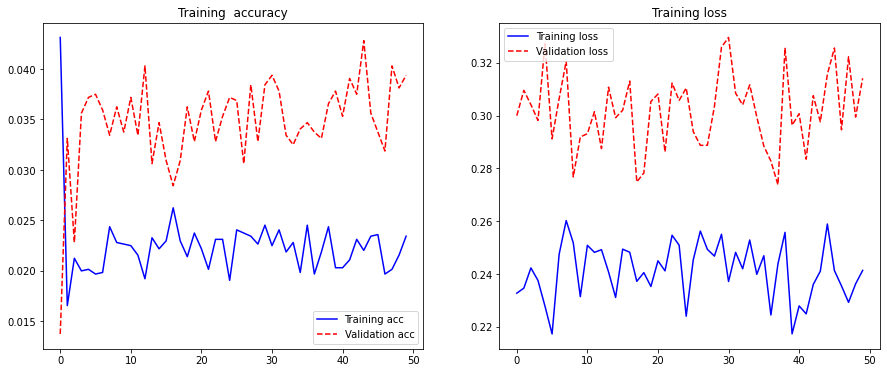

In [75]:
def plot_training_history(history):
    acc = history.history['accuracy']
    loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))
 
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r--', label='Validation acc')
    plt.title('Training  accuracy')
    plt.legend()
 
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r--', label='Validation loss')
    plt.title('Training loss')
    plt.legend()
 
    plt.show()
plot_training_history(history)

## TEST UNSEEN DATA

In [76]:
time_steps = 1000
subsample = 10
def val_generator():
    while 1:
        batch_size = 1
        x_time_data = np.zeros((batch_size, time_steps//subsample, d))
        yy = []
        for i in range(batch_size):
            random_index = np.random.randint(0, len(xtest)-time_steps)
            x_time_data[i] = xtest[random_index:random_index+time_steps:subsample]
            yy.append(ytest[random_index + time_steps])
        yy = np.asarray(yy)
        yield x_time_data, yy

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


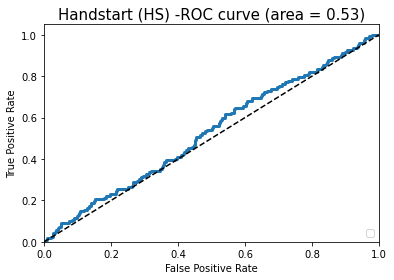

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


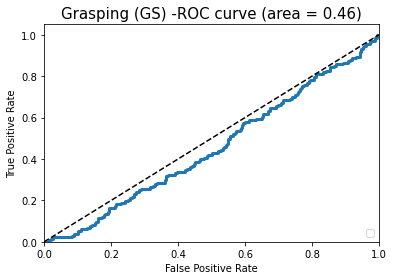

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


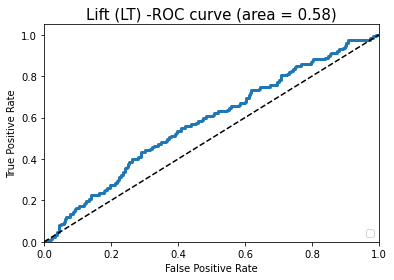

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


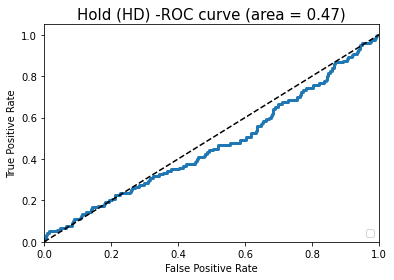

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


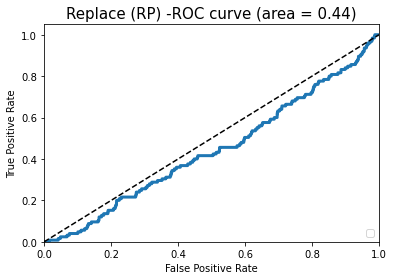

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


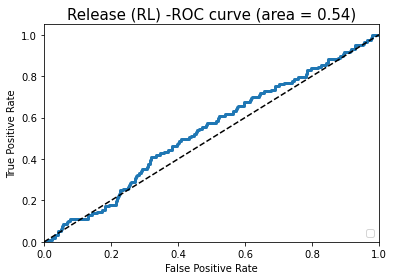

In [77]:
l=["Handstart (HS)","Grasping (GS)","Lift (LT)","Hold (HD)","Replace (RP)","Release (RL)"]
for i in range(0,6):
    plt.figure()
    plt.plot(fpr[i], tpr[i],linewidth=3)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('%s -ROC curve (area = %0.2f)' % (l[i],roc_auc[i]),fontsize= 15)
    plt.legend(loc="lower right")
    plt.show()

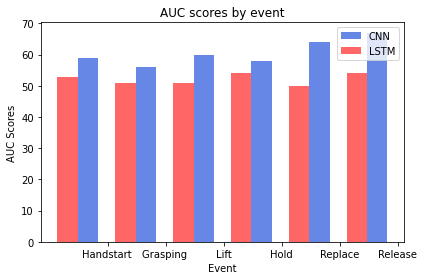

In [78]:
import numpy as np
import matplotlib.pyplot as plt

# data to plot
n_groups = 6 
means_cnn = (59,56,60,58,64,67)
means_lstm = (53,51,51,54,50,54)
           
# create plot
fig, ax = plt.subplots()

index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, means_cnn, bar_width,color='royalblue', alpha=0.8,label='CNN')

rects2 = plt.bar(index - bar_width, means_lstm, bar_width,align='center', alpha=0.6, color = 'r',label='LSTM')

plt.xlabel('Event')
plt.ylabel('AUC Scores')
plt.title('AUC scores by event')
plt.xticks(index + bar_width, ("Handstart ","Grasping ","Lift","Hold","Replace","Release"))
plt.legend()

plt.tight_layout()
plt.show()